In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from MNIST_loader import loadDataWrapper

In [2]:
(x_train, y_train), (x_val, y_val) = loadDataWrapper()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(No seed given, using 369421 instead!)
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [3]:

def train_epoch(epoch, optimizer, loss_function, model, train_loader):
    total_loss = 0
    model.train()
    
    for batch_idx, (data,label) in enumerate(train_loader):        
        optimizer.zero_grad()
        predictions, predicted_class = model(data)

        loss_value = loss_function(predictions,label)
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value.item()
    return total_loss / len(train_loader)

def validate_epoch(epoch, loss, model, val_loader):
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            predictions, predicted_class = model(data)
    
            loss_value = loss(predictions, label)
            total_loss += loss_value.item()
    return total_loss / len(val_loader)


def a_proper_training(num_epoch, model, optimizer, loss_function, train_loader, val_loader):
    best_epoch = None
    best_model = None
    best_loss = float('inf')
    train_losses = list()
    val_losses = list()

    for epoch in range(num_epoch):
      
        start_time = time.time()  # Start time
        
        val_loss = validate_epoch(epoch, loss_function, model, val_loader)
        train_loss = train_epoch(epoch, optimizer, loss_function, model, train_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
  
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{round(num_epoch, 10)}: Train Loss={round(train_loss,10)} Val Loss={round(val_loss,10)} Elapsed_time = {round(elapsed_time,2)}Seconds")
    
    return (best_model, best_epoch, train_losses, val_losses)

In [4]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 1 input channel (grayscale), 16 output channels, 3x3 convolution
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        
        # 16 input channels, 32 output channels, 3x3 convolution
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layer that takes the flattened features and outputs a tensor of size 9
        self.fc1 = nn.Linear(32 * 7 * 7, 10)  # 32 channels * 7x7 after pooling
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)  # Ensure the input has the correct shape

        # Convolution layer 1 + ReLU activation + 2x2 Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        # Convolution layer 2 + ReLU activation + 2x2 Max Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a 1D vector for the fully connected layer
        x = x.view(-1, 32 * 7 * 7)  # Flatten to batch size x 32*7*7
        
        # Fully connected layer
        x = self.fc1(x)
        
        # Apply softmax to convert the output to probabilities
        x = F.softmax(x, dim=1)  # Apply softmax along the class dimension (dim=1)
        
        # Get the class with the highest probability
        _, predicted_class = torch.max(x, dim=1)  # Take the argmax to get the predicted class
        
        return x, predicted_class  # Return the probabilities and the predicted class


In [5]:
class datasetMaker(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        x = self.X[index].float()
        y = self.Y[index].long()# - 1
        return x, y


In [6]:
#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=custom_collate, num_workers=num_workers)

batch_size = 64

trainset = datasetMaker(x_train, y_train)
trainLoader =DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, drop_last=True)
valset = datasetMaker(x_val, y_val)
valLoader =DataLoader(dataset=valset, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(trainLoader))
print(len(valLoader))

model = CNN()

epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

# Now pass the scheduler to the training function
best_model, best_epoch, train_losses, val_losses = a_proper_training(
    epochs, model, optimizer, criterion, trainLoader, valLoader
)

937
156
Epoch 1/100: Train Loss=2.3625050573 Val Loss=2.3482567378 Elapsed_time = 4.23Seconds
Epoch 2/100: Train Loss=2.3624646804 Val Loss=2.3652972808 Elapsed_time = 4.44Seconds
Epoch 3/100: Train Loss=2.3624980315 Val Loss=2.3654976013 Elapsed_time = 4.23Seconds
Epoch 4/100: Train Loss=2.362514707 Val Loss=2.3651971206 Elapsed_time = 4.27Seconds
Epoch 5/100: Train Loss=2.362514707 Val Loss=2.3654976013 Elapsed_time = 4.56Seconds
Epoch 6/100: Train Loss=2.3624813559 Val Loss=2.3652972808 Elapsed_time = 4.45Seconds
Epoch 7/100: Train Loss=2.362514707 Val Loss=2.3652972808 Elapsed_time = 4.37Seconds
Epoch 8/100: Train Loss=2.3624980315 Val Loss=2.3652972808 Elapsed_time = 4.31Seconds
Epoch 9/100: Train Loss=2.3624646804 Val Loss=2.3651971206 Elapsed_time = 4.43Seconds
Epoch 10/100: Train Loss=2.362514707 Val Loss=2.3652972808 Elapsed_time = 4.39Seconds
Epoch 11/100: Train Loss=2.362514707 Val Loss=2.3652972808 Elapsed_time = 4.49Seconds
Epoch 12/100: Train Loss=2.362514707 Val Loss=2.3

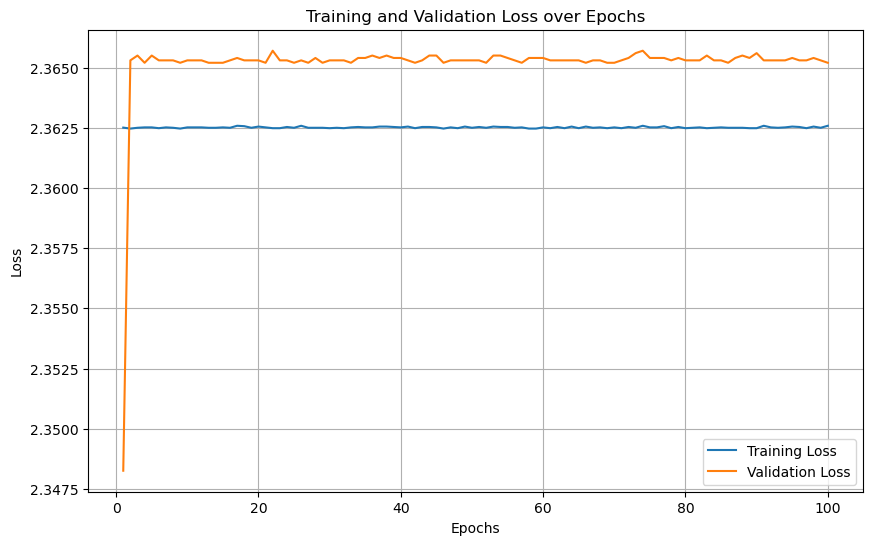

In [7]:

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))

# Plot train and validation losses
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Labeling the axes and the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Add a legend to differentiate between the two lines
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [8]:

# Save the best model to a file
torch.save(best_model.state_dict(), 'best_model.pth')
